In [1]:
import os 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

def case_preprocessing():
    dataset = list()
    only_train_dataset = list()
    df = pd.DataFrame()
    train_df = pd.DataFrame()   # 새로운 Col 만들기 
    dir_path = 'C:\\Users\\gusrl\\opendrift\\drift_trajection'
    pastDir_path = 'C:\\Users\\gusrl\\opendrift\\drift_trajection\\Past_data'
    
    for k in range(1,16):
        only_train_dataset.append(pd.read_csv(os.path.join(pastDir_path ,(str(k)+'.csv'))))
    # hour, wind(바람의 x축,y축 방향 각각 제곱합의 루트), water(해류의 x축,y축 방향 각각 제곱합의 루트)
    # 2016 (case 7)
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_003.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_005.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_010.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_011.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_015.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_016.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2016_case_040.csv')))

    # 2018(case 12)
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_005.csv')))
    # dataset_list.append(pd.read_csv(os.path.join(dir_path,'2018_case_008.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_017.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_027.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_032.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_034.csv')))
    # dataset_list.append(pd.read_csv(os.path.join(dir_path,'2018_case_045.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_047.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_082.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_083.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_090.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_095.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2018_case_097.csv')))

    # 2019(case 4)
    dataset.append(pd.read_csv(os.path.join(dir_path,'2019_case_000.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2019_case_001.csv')))
    dataset.append(pd.read_csv(os.path.join(dir_path,'2019_case_006.csv')))
    # df_2019_list.append(pd.read_csv(os.path.join(dir_path,'2019_case_007.csv'))) (제외)
    dataset.append(pd.read_csv(os.path.join(dir_path,'2019_case_005.csv')))
    
    # 과거데이터 전처리 
    for i in range(len(only_train_dataset)):
        # 시간처리를 위해 time의 object type -> datetime64로 변경
        only_train_dataset[i]['time'] = pd.to_datetime(only_train_dataset[i]['time'],format = '%Y-%m-%d %H:%M', errors = 'raise')
        # hour열 생성
        only_train_dataset[i]['hour'] = only_train_dataset[i]['time'].dt.hour
        # wind 열 생성
        only_train_dataset[i]['wind'] = (only_train_dataset[i]['wind_x']**2 + only_train_dataset[i]['wind_y']**2)**(1/2)
        # water열 생성
        only_train_dataset[i]['water'] = (only_train_dataset[i]['water_velocity_x']**2 + only_train_dataset[i]['water_velocity_y']**2)**(1/2)
        # diff_lon열 생성
        only_train_dataset[i]['diff_lon'] = only_train_dataset[i]['obs_x1_lon'].diff() 
        only_train_dataset[i]['diff_lon'][0] = 0
        # diff_lat열 생성
        only_train_dataset[i]['diff_lat'] = only_train_dataset[i]['obs_x1_lat'].diff()
        only_train_dataset[i]['diff_lat'][0] = 0
        # diff열 생성
        only_train_dataset[i]['diff'] = (only_train_dataset[i]['diff_lon']**2 + only_train_dataset[i]['diff_lat']**2)**(1/2)
        # Null 값 제외
        only_train_dataset[i] = only_train_dataset[i].dropna()
        only_train_dataset[i] = only_train_dataset[i].reset_index(drop = True)
        
        # 초기좌표 (해역 나누기)
        only_train_dataset[i]['start_lon'] = only_train_dataset[i]['obs_x1_lon'][0]
        only_train_dataset[i]['start_lat'] = only_train_dataset[i]['obs_x1_lat'][0]
        
        # Smoothing (wind_x_ma, wind_y_ma, water_velocity_x_ma, water_velocity_y_ma 인자 추가) 
        only_train_dataset[i]['wind_x_ma'] = 0
        only_train_dataset[i]['wind_y_ma'] = 0
        only_train_dataset[i]['water_velocity_x_ma'] = 0
        only_train_dataset[i]['water_velocity_y_ma'] = 0 
        for j in range(1,len(only_train_dataset[i])-1):
            only_train_dataset[i]['wind_x_ma'][j] = (only_train_dataset[i]['wind_x'][j-1] + only_train_dataset[i]['wind_x'][j] + only_train_dataset[i]['wind_x'][j+1])/3
            only_train_dataset[i]['wind_y_ma'][j] = (only_train_dataset[i]['wind_y'][j-1] + only_train_dataset[i]['wind_y'][j] + only_train_dataset[i]['wind_y'][j+1])/3
            only_train_dataset[i]['water_velocity_x_ma'][j] = (only_train_dataset[i]['water_velocity_x'][j-1] + only_train_dataset[i]['water_velocity_x'][j] + only_train_dataset[i]['water_velocity_x'][j+1])/3
            only_train_dataset[i]['water_velocity_y_ma'][j] = (only_train_dataset[i]['water_velocity_y'][j-1] + only_train_dataset[i]['water_velocity_y'][j] + only_train_dataset[i]['water_velocity_y'][j+1])/3    

    for i in range(len(dataset)):
        # 시간처리를 위해 time의 object type -> datetime64로 변경
        dataset[i]['time'] = pd.to_datetime(dataset[i]['time'],format = '%Y-%m-%d %H:%M', errors = 'raise')
        # hour열 생성
        dataset[i]['hour'] = dataset[i]['time'].dt.hour
        # wind 열 생성
        dataset[i]['wind'] = (dataset[i]['wind_x']**2 + dataset[i]['wind_y']**2)**(1/2)
        # water열 생성
        dataset[i]['water'] = (dataset[i]['water_velocity_x']**2 + dataset[i]['water_velocity_y']**2)**(1/2)
        # diff_lon열 생성
        dataset[i]['diff_lon'] = dataset[i]['obs_x1_lon'].diff() 
        dataset[i]['diff_lon'][0] = 0
        # diff_lat열 생성
        dataset[i]['diff_lat'] = dataset[i]['obs_x1_lat'].diff()
        dataset[i]['diff_lat'][0] = 0
        # diff열 생성
        dataset[i]['diff'] = (dataset[i]['diff_lon']**2 + dataset[i]['diff_lat']**2)**(1/2)
        # Null 값 제외
        dataset[i] = dataset[i].dropna()
        dataset[i] = dataset[i].reset_index(drop = True)
        
        # 초기좌표 (해역 나누기)
        dataset[i]['start_lon'] = dataset[i]['obs_x1_lon'][0]
        dataset[i]['start_lat'] = dataset[i]['obs_x1_lat'][0]
        
        # Smoothing (wind_x_ma, wind_y_ma, water_velocity_x_ma, water_velocity_y_ma 인자 추가) 
        dataset[i]['wind_x_ma'] = 0
        dataset[i]['wind_y_ma'] = 0
        dataset[i]['water_velocity_x_ma'] = 0
        dataset[i]['water_velocity_y_ma'] = 0 
        for j in range(1,len(dataset[i])-1):
            dataset[i]['wind_x_ma'][j] = (dataset[i]['wind_x'][j-1] + dataset[i]['wind_x'][j] + dataset[i]['wind_x'][j+1])/3
            dataset[i]['wind_y_ma'][j] = (dataset[i]['wind_y'][j-1] + dataset[i]['wind_y'][j] + dataset[i]['wind_y'][j+1])/3
            dataset[i]['water_velocity_x_ma'][j] = (dataset[i]['water_velocity_x'][j-1] + dataset[i]['water_velocity_x'][j] + dataset[i]['water_velocity_x'][j+1])/3
            dataset[i]['water_velocity_y_ma'][j] = (dataset[i]['water_velocity_y'][j-1] + dataset[i]['water_velocity_y'][j] + dataset[i]['water_velocity_y'][j+1])/3
        
        # 삭제 전 원본 df
        df = pd.concat([df,dataset[i]],ignore_index = True)
        # 불필요열 삭제 
        pre_df = dataset[i].drop(columns = ['time','obs_x1_lon','obs_x1_lat','model_x2_lon','model_x2_lat'])  
        train_df = pd.concat([train_df, pre_df[1:-1]],ignore_index = True)
        
    df = df.reset_index(drop = True)
    train_df = train_df.reset_index(drop = True)
    return dataset, df, train_df, only_train_dataset

def drift_mae(y, predict_y):
    mae = mean_absolute_error(y, predict_y)
    return mae


def n2_mae(y, predict_y):
    n = y.shape[0]
    error_sum = 0
    
    for i in range(n):
        error_sum += abs((y[i][0] - predict_y[i][0])) + abs(( y[i][1] - predict_y[i][1]))
    
    mae = error_sum/(2*n)   
    
    return mae


def paper_mae(y, predict_y): # 논문  
    n = y.shape[0]
    error_sum = 0
    
    for i in range(n):
        error_sum += abs(y[i][0] - predict_y[i][0]) + abs(y[i][1] - predict_y[i][1])
    
    mae = error_sum/n    
    return mae

def NCLS_score(y, predict_y): # 1시간 
        # dl_i 구하기 
        dl_list, dl_sum, o_sum = list(), list(), 0
        n = y.shape[0]
        for i in range(1, n):
            # 위도 1도는 111.321, 경도 1도는 87.74km, 단위 km
            d_lon = y[i][0] - y[i-1][0]  
            d_lat = y[i][1] - y[i-1][1]
            # 거리 구하기
            point_distance = np.sqrt(np.power(d_lon,2) + np.power(d_lat,2))
            dl_list.append(point_distance)
            
        for i in range(len(dl_list)):
            temp = 0
            for j in range(i+1):
                temp += dl_list[j]
            dl_sum.append(temp)

        for i in range(len(dl_sum)):
            o_sum += dl_sum[i]
        
        # 예측모델의 d_i 구하기
        d_list = list()
        for i in range(1,n):
            # 위도 1도는 111.321 # 경도 1도는 55.802km
            d_lon = y[i][0] - predict_y[i][0]  
            d_lat = y[i][1] - predict_y[i][1]
            # 거리 구하기
            point_distance = np.sqrt(np.power(d_lon,2) + np.power(d_lat,2))
            d_list.append(point_distance)

        # s 구하기
        d_sum, s, ss_score = 0, 0, 0

        for i in range(len(d_list)):
            d_sum += d_list[i]

        s = d_sum/o_sum
        
        if s > 1:
                ss_score = 0
        else:
            ss_score = 1-s
        
        return ss_score

def drift_trajection_show(index, y_pred): 
    %matplotlib inline

    # 실제 위치
    lon = dataset[index]['obs_x1_lon']
    lon = np.array(lon)
    lat = dataset[index]['obs_x1_lat']
    lat = np.array(lat)
    
    # baseline
    baseline_lon = dataset[index]['model_x2_lon']
    baseline_lon = np.array(baseline_lon)
    baseline_lat = dataset[index]['model_x2_lat']
    baseline_lat = np.array(baseline_lat)

    # 예측값 
    first_lon = lon[0]
    first_lat = lat[0]
    lon_pred = np.zeros((y_pred.shape[0]+1,))
    lat_pred = np.zeros((y_pred.shape[0]+1,))
    lon_pred[0] = first_lon 
    lat_pred[0] = first_lat
    
    for i in range(1, lon_pred.shape[0]):
        lon_pred[i] = lon_pred[i-1] + y_pred[i-1][0]
        lat_pred[i] = lat_pred[i-1] + y_pred[i-1][1]
        
    return lon, lat, baseline_lon, baseline_lat, lon_pred, lat_pred

def std_scaler(train_X, test_X):
    from sklearn.preprocessing import StandardScaler
    std = StandardScaler()
    std.fit(train_X)
    train_X_scaled = std.transform(train_X)
    test_X_scaled = std.transform(test_X)
    return train_X_scaled, test_X_scaled

def MinMax_scaler(train_X, test_X):
    from sklearn.preprocessing import MinMaxScaler
    mms = MinMaxScaler()
    mms.fit(train_X)
    train_X_scaled = mms.transform(train_X)
    test_X_scaled = mms.transform(test_X)
    return train_X_scaled, test_X_scaled
    
def roburst_scaler(train_X, test_X):
    from sklearn.preprocessing import RobustScaler
    rbs = RobustScaler()
    train_X_scaled = rbs.fit_transform(train_X)
    test_X_scaled = rbs.transform(test_X)
    return train_X_scaled, test_X_scaled


def maxAbsScaler(train_X, test_X):

    from sklearn.preprocessing import MaxAbsScaler
    maxAbsScaler = MaxAbsScaler()
    train_X_scaled = maxAbsScaler.fit_transform(train_X)
    test_X_scaled = maxAbsScaler.transform(test_X)
    return train_X_scaled, test_X_scaled


In [2]:
dataset, concat_df, train_df, only_train_dataset = case_preprocessing()

C:\Users\gusrl\AppData\Local\Temp\ipykernel_16620\4280760974.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_dataset[i]['diff_lon'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_16620\4280760974.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_dataset[i]['diff_lat'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_16620\4280760974.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_data

C:\Users\gusrl\AppData\Local\Temp\ipykernel_16620\4280760974.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_dataset[i]['diff_lon'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_16620\4280760974.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_dataset[i]['diff_lat'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_16620\4280760974.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_train_data

C:\Users\gusrl\AppData\Local\Temp\ipykernel_16620\4280760974.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['diff_lon'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_16620\4280760974.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['diff_lat'][0] = 0
C:\Users\gusrl\AppData\Local\Temp\ipykernel_16620\4280760974.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i]['wind_x_ma'][j] = (datas

--------------------- Model  0  ----------------------
Model 0  MAE :  0.39744604166657804
Model 0  NCLS :  0
--------------------- Model  1  ----------------------
Model 1  MAE :  0.15019375000011762
Model 1  NCLS :  0.5903738396020491
--------------------- Model  2  ----------------------
Model 2  MAE :  0.26843361111110486
Model 2  NCLS :  0.44715021412413636
--------------------- Model  3  ----------------------
Model 3  MAE :  0.09921376760554493
Model 3  NCLS :  0.5120958219470122
--------------------- Model  4  ----------------------
Model 4  MAE :  0.4227750352111437
Model 4  NCLS :  0.02384767513219932
--------------------- Model  5  ----------------------
Model 5  MAE :  0.21896034722235555
Model 5  NCLS :  0.42396406788422847
--------------------- Model  6  ----------------------
Model 6  MAE :  0.4266274999998495
Model 6  NCLS :  0.22037562286334078
--------------------- Model  7  ----------------------
Model 7  MAE :  0.18429256944454414
Model 7  NCLS :  0.5857888869296018

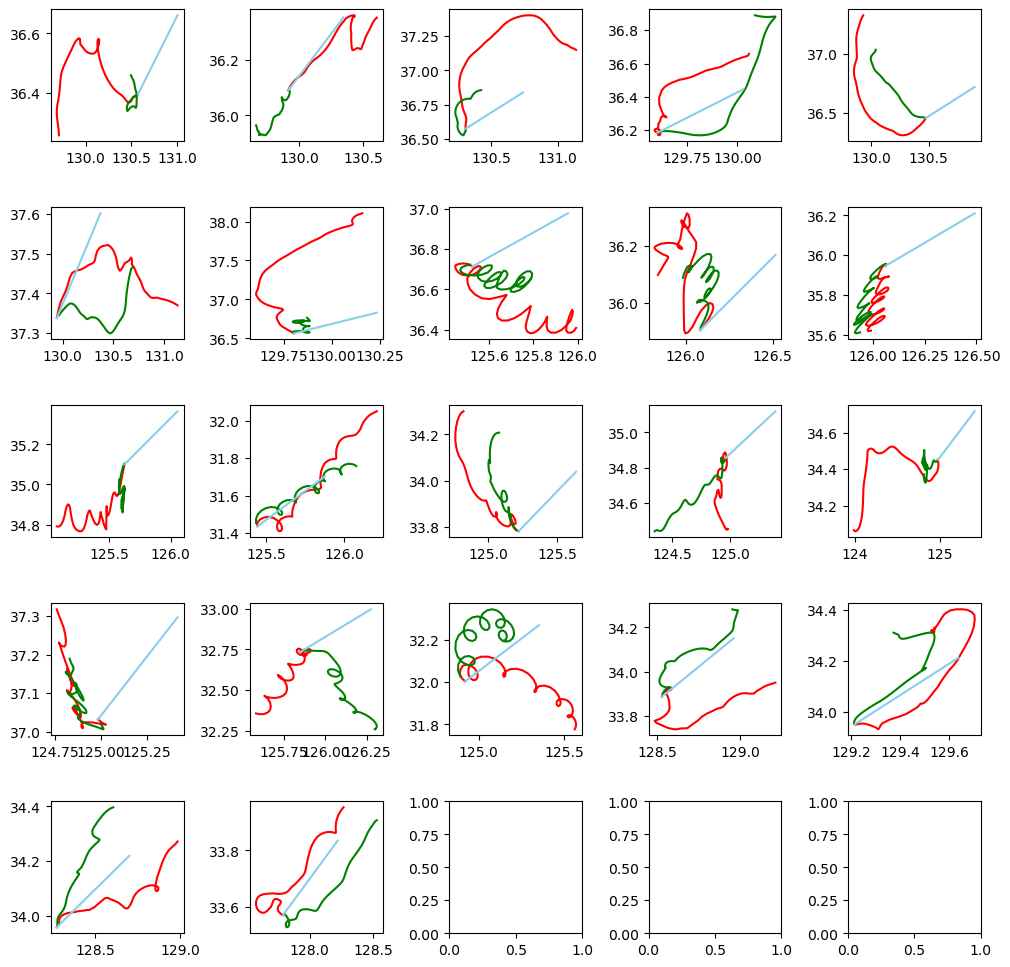

In [7]:
# SVR model (Feature 4개) & roburst & poly

from sklearn.svm import SVR
f, axes = plt.subplots(5, 5)
# 격자 크기 설정
f.set_size_inches((12, 12))
# 격자 여백 설정
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
MAE_list = list()
NCLS_list = list()

for i in range(len(dataset)):
    print( '--------------------- Model ', i,' ----------------------')
    # train dataset
    train_X = pd.DataFrame()
    train_y = np.array([[]])
    train = dataset[0:i] + dataset[i+1:len(dataset)]

    train_X = train[0][['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x']]
    train_y_lon = train[0]['diff_lon']
    train_y_lat = train[0]['diff_lat']

    # 첫 행은 훈련에서 제외
    train_X = train_X[1:]
    train_y_lon = train_y_lon[1:].to_numpy()
    train_y_lat = train_y_lat[1:].to_numpy()

    for j in range(1,len(train)):
        train_xi = train[j][['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x']] 
        train_yi_lon = train[j]['diff_lon']
        train_yi_lat = train[j][ 'diff_lat']
        
        train_xi = train_xi[1:]
        train_yi_lon = train_yi_lon[1:].to_numpy()
        train_yi_lat = train_yi_lat[1:].to_numpy()
        
        train_X = pd.concat([train_X,train_xi],ignore_index = True)
        train_y_lon = np.concatenate((train_y_lon,train_yi_lon), axis = 0)
        train_y_lat = np.concatenate((train_y_lat,train_yi_lat), axis = 0)
        
     # 과거 데이터 훈련데이터에 추가
    for k in range(len(only_train_dataset)):
        train_xi = only_train_dataset[k][['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x']] 
        train_yi_lon = only_train_dataset[k]['diff_lon']
        train_yi_lat = only_train_dataset[k]['diff_lat']
        
        train_xi = train_xi[1:]
        train_yi_lon = train_yi_lon[1:].to_numpy()
        train_yi_lat = train_yi_lat[1:].to_numpy()
      
        train_X = pd.concat([train_X, train_xi],ignore_index = True)
        train_y_lon = np.concatenate((train_y_lon,train_yi_lon), axis = 0) 
        train_y_lat = np.concatenate((train_y_lat,train_yi_lat), axis = 0) 
   
    # Test dataset
    train_y
    test = dataset[i]
    test_X = test[['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x']]
    test_X = test_X[1:]
    test_y_lon = test['diff_lon']
    test_y_lat = test['diff_lat']
    test_y_lon = test_y_lon[1:].to_numpy()
    test_y_lat = test_y_lat[1:].to_numpy()
    
    train_X, test_X = maxAbsScaler(train_X, test_X)
    
    # SVR_lon,lat 모델 생성
    SVR_lon = SVR(kernel='poly')
    SVR_lon.fit(train_X, train_y_lon)
    # ,gamma = 0.01, C = 10000
    SVR_lat = SVR(kernel='poly')
    SVR_lat.fit(train_X, train_y_lat)
    
    # model save
    #SVR.save(str(i)+'RDF_model.h5')

    # Predict
    y_pred_lon = SVR_lon.predict(test_X)
    y_pred_lat = SVR_lat.predict(test_X)
    y_pred_lon = y_pred_lon.reshape((y_pred_lon.shape[0],1))
    y_pred_lat = y_pred_lat.reshape((y_pred_lat.shape[0],1))
    y_pred = np.concatenate((y_pred_lon, y_pred_lat),axis=1)
    
    # Plot
    lon, lat, baseline_lon, baseline_lat, lon_pred, lat_pred = drift_trajection_show(i,y_pred)
    row = i//5
    col = i%5
    axes[row][col].plot(lon, lat,'r-' ,baseline_lon, baseline_lat, 'g-', lon_pred, lat_pred, 'skyblue')   
    
    # evaluation 
    y = np.concatenate((lon.reshape((lon.shape[0],1)), lat.reshape((lat.shape[0],1))),axis = 1)
    pred = np.concatenate((lon_pred.reshape((lon_pred.shape[0],1)), lat_pred.reshape((lat_pred.shape[0],1))),axis =1)
    
    #mae
    print('Model',str(i),' MAE : ', drift_mae(y, pred))
    MAE_list.append(drift_mae(y, pred))
    
    #NCLS
    print('Model',str(i),' NCLS : ', NCLS_score(y, pred))
    NCLS_list.append(NCLS_score(y, pred))

plt.show()

In [8]:
# 특성 4개 & roburst
mae_sum = 0
NCLS_sum = 0
for i in range(len(dataset)):
    mae_sum += MAE_list[i]
    NCLS_sum += NCLS_list[i]

# 라이브러리 Mae    
print ('평균 Mae : ', mae_sum/len(dataset) )
print ('평균 NCLS : ', NCLS_sum/len(dataset) )

평균 Mae :  0.23687249424957366
평균 NCLS :  0.36910696620561373


--------------------- Model  0  ----------------------
Model 0  MAE :  0.43050923611088654
Model 0  NCLS :  0
--------------------- Model  1  ----------------------
Model 1  MAE :  0.24630861111128263
Model 1  NCLS :  0.3404390276891338
--------------------- Model  2  ----------------------
Model 2  MAE :  0.20533159722237374
Model 2  NCLS :  0.5682551434251517
--------------------- Model  3  ----------------------
Model 3  MAE :  0.11694749999993304
Model 3  NCLS :  0.45650288947925866
--------------------- Model  4  ----------------------
Model 4  MAE :  0.361671021126587
Model 4  NCLS :  0.17124616248408142
--------------------- Model  5  ----------------------
Model 5  MAE :  0.3417304861112702
Model 5  NCLS :  0.19208510547955726
--------------------- Model  6  ----------------------
Model 6  MAE :  0.2979069444444419
Model 6  NCLS :  0.4476345297558193
--------------------- Model  7  ----------------------
Model 7  MAE :  0.31759944444457217
Model 7  NCLS :  0.3432689198279665
--

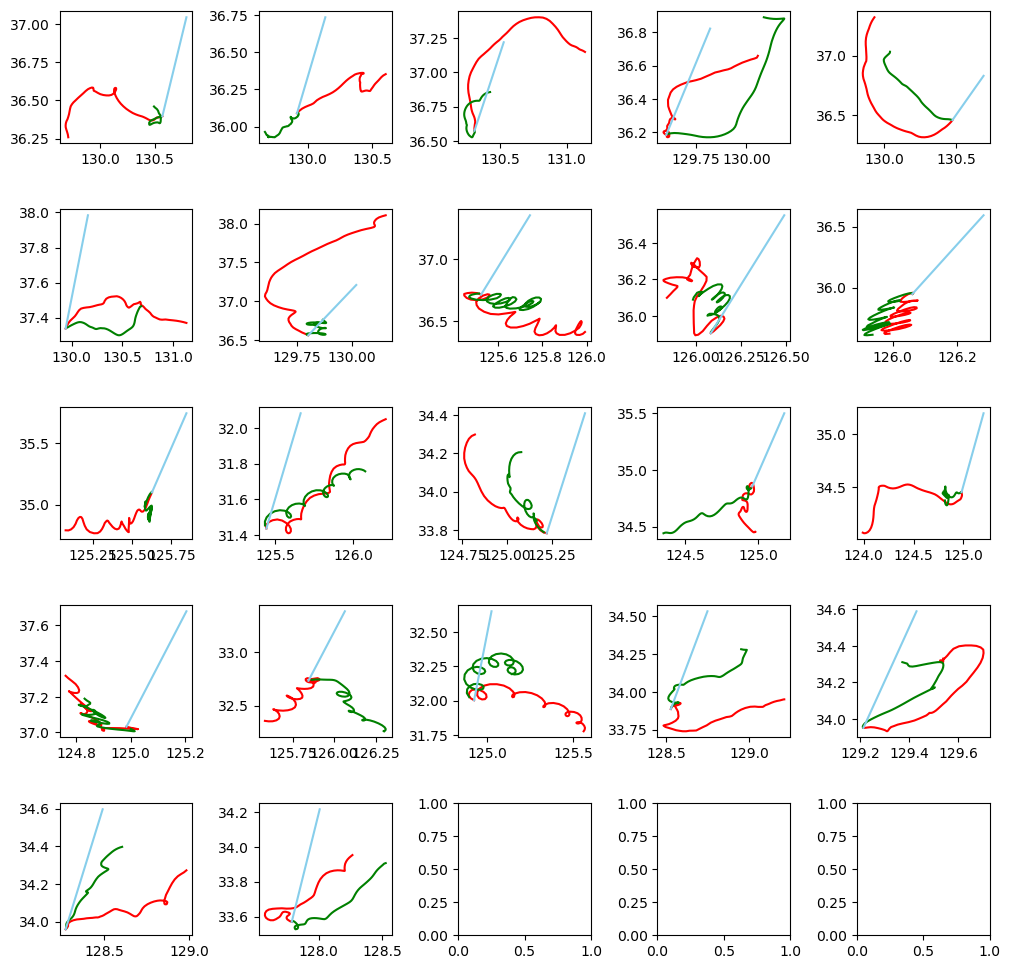

In [15]:
# SVR model (Feature 4개) & roburst & poly

from sklearn.svm import SVR
f, axes = plt.subplots(5, 5)
# 격자 크기 설정
f.set_size_inches((12, 12))
# 격자 여백 설정
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
MAE_list = list()
NCLS_list = list()

for i in range(len(dataset)):
    print( '--------------------- Model ', i,' ----------------------')
    # train dataset
    train_X = pd.DataFrame()
    train_y = np.array([[]])
    train = dataset[0:i] + dataset[i+1:len(dataset)]

    train_X = train[0][['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x']]
    train_y_lon = train[0]['diff_lon']
    train_y_lat = train[0]['diff_lat']

    # 첫 행은 훈련에서 제외
    train_X = train_X[1:]
    train_y_lon = train_y_lon[1:].to_numpy()
    train_y_lat = train_y_lat[1:].to_numpy()

    for j in range(1,len(train)):
        train_xi = train[j][['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x']] 
        train_yi_lon = train[j]['diff_lon']
        train_yi_lat = train[j][ 'diff_lat']
        
        train_xi = train_xi[1:]
        train_yi_lon = train_yi_lon[1:].to_numpy()
        train_yi_lat = train_yi_lat[1:].to_numpy()
        
        train_X = pd.concat([train_X,train_xi],ignore_index = True)
        train_y_lon = np.concatenate((train_y_lon,train_yi_lon), axis = 0)
        train_y_lat = np.concatenate((train_y_lat,train_yi_lat), axis = 0)
   
    # Test dataset
    train_y
    test = dataset[i]
    test_X = test[['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x']]
    test_X = test_X[1:]
    test_y_lon = test['diff_lon']
    test_y_lat = test['diff_lat']
    test_y_lon = test_y_lon[1:].to_numpy()
    test_y_lat = test_y_lat[1:].to_numpy()
    
    train_X, test_X = maxAbsScaler(train_X, test_X)
    
    # SVR_lon,lat 모델 생성
    SVR_lon = SVR(kernel='rbf')
    SVR_lon.fit(train_X, train_y_lon)
    SVR_lat = SVR(kernel='rbf')
    SVR_lat.fit(train_X, train_y_lat)
    
    # model save
    #SVR.save(str(i)+'RDF_model.h5')

    # Predict
    y_pred_lon = SVR_lon.predict(test_X)
    y_pred_lat = SVR_lat.predict(test_X)
    y_pred_lon = y_pred_lon.reshape((y_pred_lon.shape[0],1))
    y_pred_lat = y_pred_lat.reshape((y_pred_lat.shape[0],1))
    y_pred = np.concatenate((y_pred_lon, y_pred_lat),axis=1)
    
    # Plot
    lon, lat, baseline_lon, baseline_lat, lon_pred, lat_pred = drift_trajection_show(i,y_pred)
    row = i//5
    col = i%5
    axes[row][col].plot(lon, lat,'r-' ,baseline_lon, baseline_lat, 'g-', lon_pred, lat_pred, 'skyblue')   
    
    # evaluation 
    y = np.concatenate((lon.reshape((lon.shape[0],1)), lat.reshape((lat.shape[0],1))),axis = 1)
    pred = np.concatenate((lon_pred.reshape((lon_pred.shape[0],1)), lat_pred.reshape((lat_pred.shape[0],1))),axis =1)
    
    #mae
    print('Model',str(i),' MAE : ', drift_mae(y, pred))
    MAE_list.append(drift_mae(y, pred))
    
    #NCLS
    print('Model',str(i),' NCLS : ', NCLS_score(y, pred))
    NCLS_list.append(NCLS_score(y, pred))

plt.show()

In [16]:
# 특성 4개 & roburst
mae_sum = 0
NCLS_sum = 0
for i in range(len(dataset)):
    mae_sum += MAE_list[i]
    NCLS_sum += NCLS_list[i]

# 라이브러리 Mae    
print ('평균 Mae : ', mae_sum/len(dataset) )
print ('평균 NCLS : ', NCLS_sum/len(dataset) )

평균 Mae :  0.2821398675296322
평균 NCLS :  0.27749937351394977


--------------------- Model  0  ----------------------
Model 0  MAE :  0.43050923611088654
Model 0  NCLS :  0
--------------------- Model  1  ----------------------
Model 1  MAE :  0.24630861111128263
Model 1  NCLS :  0.3404390276891338
--------------------- Model  2  ----------------------
Model 2  MAE :  0.20533159722237374
Model 2  NCLS :  0.5682551434251517
--------------------- Model  3  ----------------------
Model 3  MAE :  0.11694749999993304
Model 3  NCLS :  0.45650288947925866
--------------------- Model  4  ----------------------
Model 4  MAE :  0.361671021126587
Model 4  NCLS :  0.17124616248408142
--------------------- Model  5  ----------------------
Model 5  MAE :  0.3417304861112702
Model 5  NCLS :  0.19208510547955726
--------------------- Model  6  ----------------------
Model 6  MAE :  0.2979069444444419
Model 6  NCLS :  0.4476345297558193
--------------------- Model  7  ----------------------
Model 7  MAE :  0.31759944444457217
Model 7  NCLS :  0.3432689198279665
--

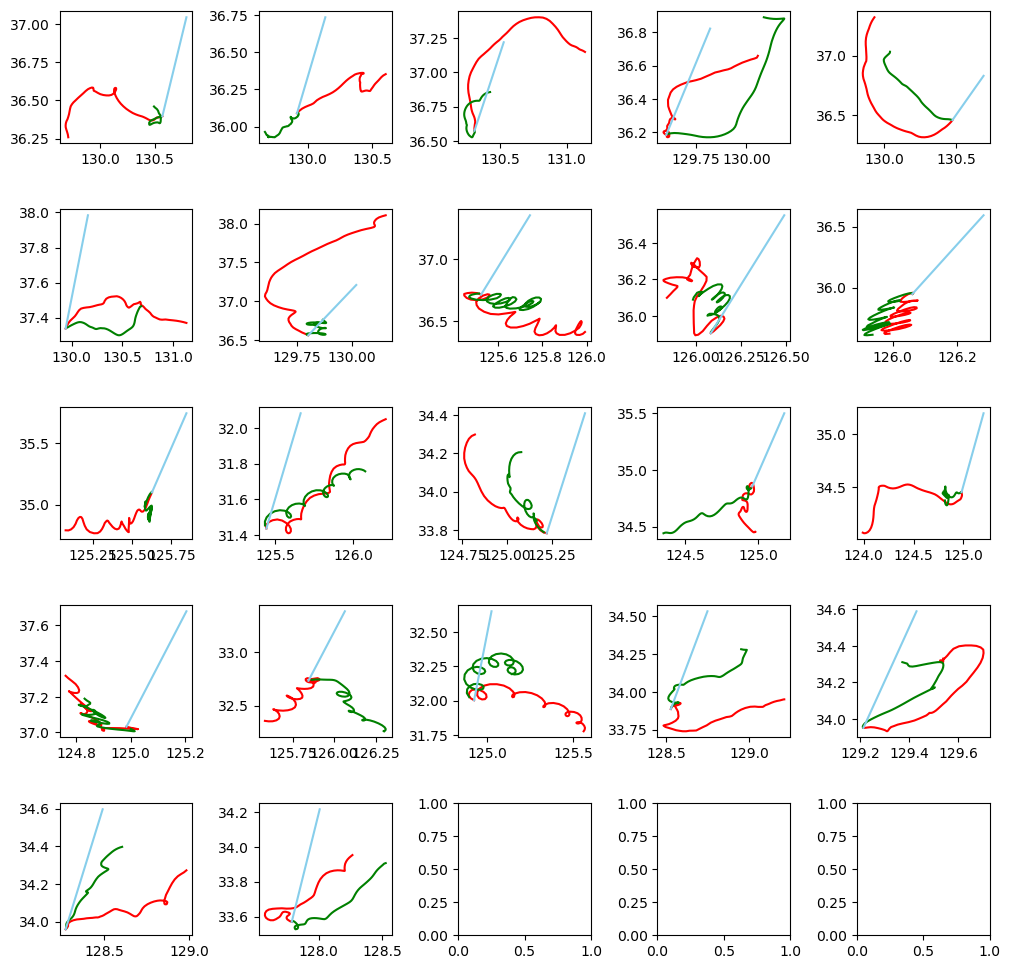

In [7]:
# SVR model (Feature 4개) & roburst

from sklearn.svm import SVR
f, axes = plt.subplots(5, 5)
# 격자 크기 설정
f.set_size_inches((12, 12))
# 격자 여백 설정
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
MAE_list = list()
NCLS_list = list()

for i in range(len(dataset)):
    print( '--------------------- Model ', i,' ----------------------')
    # train dataset
    train_X = pd.DataFrame()
    train_y = np.array([[]])
    train = dataset[0:i] + dataset[i+1:len(dataset)]

    train_X = train[0][['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x']]
    train_y_lon = train[0]['diff_lon']
    train_y_lat = train[0]['diff_lat']

    # 첫 행은 훈련에서 제외
    train_X = train_X[1:]
    train_y_lon = train_y_lon[1:].to_numpy()
    train_y_lat = train_y_lat[1:].to_numpy()

    for j in range(1,len(train)):
        train_xi = train[j][['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x']] 
        train_yi_lon = train[j]['diff_lon']
        train_yi_lat = train[j][ 'diff_lat']
        
        train_xi = train_xi[1:]
        train_yi_lon = train_yi_lon[1:].to_numpy()
        train_yi_lat = train_yi_lat[1:].to_numpy()
        
        train_X = pd.concat([train_X,train_xi],ignore_index = True)
        train_y_lon = np.concatenate((train_y_lon,train_yi_lon), axis = 0)
        train_y_lat = np.concatenate((train_y_lat,train_yi_lat), axis = 0)
   
    # Test dataset
    train_y
    test = dataset[i]
    test_X = test[['wind_x', 'wind_y', 'water_velocity_y', 'water_velocity_x']]
    test_X = test_X[1:]
    test_y_lon = test['diff_lon']
    test_y_lat = test['diff_lat']
    test_y_lon = test_y_lon[1:].to_numpy()
    test_y_lat = test_y_lat[1:].to_numpy()
    
    train_X, test_X = roburst_scaler(train_X, test_X)
    
    # SVR_lon,lat 모델 생성
    SVR_lon = SVR(kernel='linear')
    SVR_lon.fit(train_X, train_y_lon)
    SVR_lat = SVR(kernel='linear')
    SVR_lat.fit(train_X, train_y_lat)
    
    # model save
    #SVR.save(str(i)+'RDF_model.h5')

    # Predict
    y_pred_lon = SVR_lon.predict(test_X)
    y_pred_lat = SVR_lat.predict(test_X)
    y_pred_lon = y_pred_lon.reshape((y_pred_lon.shape[0],1))
    y_pred_lat = y_pred_lat.reshape((y_pred_lat.shape[0],1))
    y_pred = np.concatenate((y_pred_lon, y_pred_lat),axis=1)
    
    # Plot
    lon, lat, baseline_lon, baseline_lat, lon_pred, lat_pred = drift_trajection_show(i,y_pred)
    row = i//5
    col = i%5
    axes[row][col].plot(lon, lat,'r-' ,baseline_lon, baseline_lat, 'g-', lon_pred, lat_pred, 'skyblue')   
    
    # evaluation 
    y = np.concatenate((lon.reshape((lon.shape[0],1)), lat.reshape((lat.shape[0],1))),axis = 1)
    pred = np.concatenate((lon_pred.reshape((lon_pred.shape[0],1)), lat_pred.reshape((lat_pred.shape[0],1))),axis =1)
    
    #mae
    print('Model',str(i),' MAE : ', drift_mae(y, pred))
    MAE_list.append(drift_mae(y, pred))
    
    #NCLS
    print('Model',str(i),' NCLS : ', NCLS_score(y, pred))
    NCLS_list.append(NCLS_score(y, pred))

plt.show()

In [8]:
# 특성 4개 & roburst
mae_sum = 0
NCLS_sum = 0
for i in range(len(dataset)):
    mae_sum += MAE_list[i]
    NCLS_sum += NCLS_list[i]

# 라이브러리 Mae    
print ('평균 Mae : ', mae_sum/len(dataset) )
print ('평균 NCLS : ', NCLS_sum/len(dataset) )

평균 Mae :  0.2821398675296322
평균 NCLS :  0.27749937351394977
